# Task 6: Building a Baseline model using SVM

# EEG Seizure Classification Model Documentation

This Python script is designed for classifying EEG (Electroencephalogram) data into different seizure categories using a baseline machine learning model: Support Vector Machine (SVM). It also includes an experimental implementation of the XGBoost model for comparison. The script handles data loading, feature extraction, training, evaluation, and prediction.

## Requirements
- numpy
- torch
- sklearn
- seaborn
- matplotlib
- pandas
- xgboost (for experimental model)

## Code Overview

### 1. Import Libraries
- `numpy`: Used for numerical operations.
- `os`: For file and directory path handling.
- `torch`: For machine learning framework used for dataset handling.
- `sklearn`: For SVM, scaling, and evaluation metrics.
- `seaborn` and `matplotlib`: For data visualization (confusion matrix).
- `pandas`: For handling CSV outputs.
- `xgboost`: For experimenting with the XGBoost model (not the baseline model).

### 2. Data Loading

#### Paths
- The data is expected to be in a Kaggle dataset at the given base path `/kaggle/input/impulse/Impulse/EEG_Data` containing subfolders for training, validation, and test data.

#### Labeled Data
Labeled data is loaded using the `load_labeled_data()` function. It reads the EEG data files from the respective class folders, assigning the corresponding class label.

#### Unlabeled Data
The unlabeled data is loaded using `load_unlabeled_data()` for test data, storing both the EEG data and filenames.

### 3. Data Normalization

The data is normalized by calculating the mean and standard deviation across samples and channels. This ensures that the data has zero mean and unit variance, making it more suitable for training.

### 4. Feature Extraction

The `extract_features()` function extracts two types of features from the EEG data:
- **FFT (Fast Fourier Transform)**: Converts the signal from time domain to frequency domain.
- **Zero Crossing Rate (ZCR)**: Counts the number of times the signal crosses zero, indicating signal variability.

Both features are concatenated and returned as the final feature set for each sample.

### 5. SVM Model Training (Baseline Model)

#### Model Initialization
- The baseline model used is an SVM with a Radial Basis Function (RBF) kernel, initialized with a regularization parameter `C=1.0` and `gamma='scale'`.

#### Training and Evaluation
- The model is trained on the extracted training features.
- Predictions are made on the validation set, and various metrics are computed:
  - **Accuracy**
  - **Balanced Accuracy**
  - **F1 Score** (weighted)
  - **ROC AUC Score** (One-vs-Rest multi-class approach)
  - **Confusion Matrix** (visualized using a heatmap)

#### Saving Predictions
- The predictions for the unlabeled test data are saved to a CSV file `test_predictions.csv`.

### 6. Experimental XGBoost Model Training

While SVM serves as the baseline model, XGBoost is included for comparison as an additional model.

#### Model Initialization
- The XGBoost model is initialized with hyperparameters such as:
  - `n_estimators=100`: Number of trees.
  - `max_depth=6`: Maximum depth of trees.
  - `learning_rate=0.1`: Step size shrinkage.
  - `subsample=0.8`: Subsample ratio.
  - `colsample_bytree=0.8`: Subsample ratio of columns when constructing each tree.

#### Training and Evaluation
- The XGBoost model is trained similarly to the SVM model, and predictions are made on the validation set.
- Evaluation metrics are calculated and displayed:
  - **Accuracy**
  - **F1 Score** (weighted)
  - **Confusion Matrix** (visualized using a heatmap)

#### Saving Predictions
- The predictions for the unlabeled test data are saved to a CSV file `xgb_test_predictions.csv`.

### 7. Conclusion
- The baseline model, SVM, is trained, evaluated, and used to predict test data.
- The experimental model, XGBoost, is also trained for comparison.
- Evaluation results for both models are printed, including accuracy, F1 score, and confusion matrices.
- Test predictions are saved to CSV files for further analysis.

# 1. Importing Libraries


In [1]:
import numpy as np
import os
import torch
from torch.utils.data import Dataset
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, roc_auc_score, balanced_accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# 2. Utility Functions


In [2]:

# Paths
base_path = "/kaggle/input/impulse/Impulse/EEG_Data"
train_path = os.path.join(base_path, "train_data")
val_path = os.path.join(base_path, "validation_data")
test_path = os.path.join(base_path, "test_data")

class_mapping = {
    "Normal": 0,
    "Complex_Partial_Seizures": 1,
    "Electrographic_Seizures": 2,
    "Video_detected_Seizures_with_no_visual_change_over_EEG": 3,
}

def load_labeled_data(data_path, class_mapping):
    data, labels = [], []
    for class_name, label in class_mapping.items():
        class_folder = os.path.join(data_path, class_name)
        if os.path.exists(class_folder):
            for file in os.listdir(class_folder):
                if file.endswith(".npy"):
                    sample = np.load(os.path.join(class_folder, file))
                    data.append(sample)
                    labels.append(label)
    return np.array(data), np.array(labels)

def load_unlabeled_data(data_path):
    data, filenames = [], []
    for file in os.listdir(data_path):
        if file.endswith(".npy"):
            sample = np.load(os.path.join(data_path, file))
            data.append(sample)
            filenames.append(file)
    return np.array(data), filenames

# 3. Data Loading


In [3]:
train_data, train_labels = load_labeled_data(train_path, class_mapping)
val_data, val_labels = load_labeled_data(val_path, class_mapping)
test_data, test_filenames = load_unlabeled_data(test_path)

In [4]:
# Normalize Data
def normalize_data(data):
    mean = data.mean(axis=(0, 2), keepdims=True)
    std = data.std(axis=(0, 2), keepdims=True) + 1e-8
    return (data - mean) / std

train_data = normalize_data(train_data)
val_data = normalize_data(val_data)
test_data = normalize_data(test_data)

In [5]:
def extract_features(data):
    """
    Extract FFT and ZCR features from EEG data.
    Args:
        data (numpy array): Shape (num_samples, num_channels, num_points)
    Returns:
        features (numpy array): Extracted features of shape (num_samples, total_features)
    """
    num_samples, num_channels, num_points = data.shape
    fft_features = []
    zcr_features = []

    for sample in range(num_samples):
        sample_fft_features = []
        sample_zcr_features = []
        
        for channel in range(num_channels):
            # Fourier Transform (FFT)
            fft = np.fft.rfft(data[sample, channel])
            fft_magnitude = np.abs(fft)  # Take magnitude
            sample_fft_features.extend(fft_magnitude)

            # Zero Crossing Rate (ZCR)
            signal = data[sample, channel]
            zcr = ((signal[:-1] * signal[1:]) < 0).sum()  # Count zero crossings
            sample_zcr_features.append(zcr)
        
        fft_features.append(sample_fft_features)
        zcr_features.append(sample_zcr_features)

    # Combine FFT and ZCR features
    fft_features = np.array(fft_features)  # Shape: (num_samples, num_channels * fft_length)
    zcr_features = np.array(zcr_features)  # Shape: (num_samples, num_channels)
    return np.hstack((fft_features, zcr_features))  # Concatenate along feature axis

# Extract features
train_features = extract_features(train_data)  # Shape: (num_samples, total_features)
val_features = extract_features(val_data)      # Shape: (num_samples, total_features)
test_features = extract_features(test_data)    # Shape: (num_samples, total_features)

# Normalize features
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)
val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

# 4. SVM Training

In [6]:
svm_model = SVC(kernel='rbf', C=1.0, gamma='scale')  # You can tune hyperparameters
svm_model.fit(train_features, train_labels)

SVC()

# 5. Validation and Calculating metrics 

SVM Validation Accuracy: 0.9152
SVM Balanced Accuracy: 0.8003
SVM F1 Score: 0.9134
SVM ROC AUC Score: 0.9651
SVM Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.99      0.93       696
           1       0.95      0.85      0.90       549
           2       0.98      0.89      0.93       137
           3       1.00      0.48      0.65        21

    accuracy                           0.92      1403
   macro avg       0.95      0.80      0.85      1403
weighted avg       0.92      0.92      0.91      1403



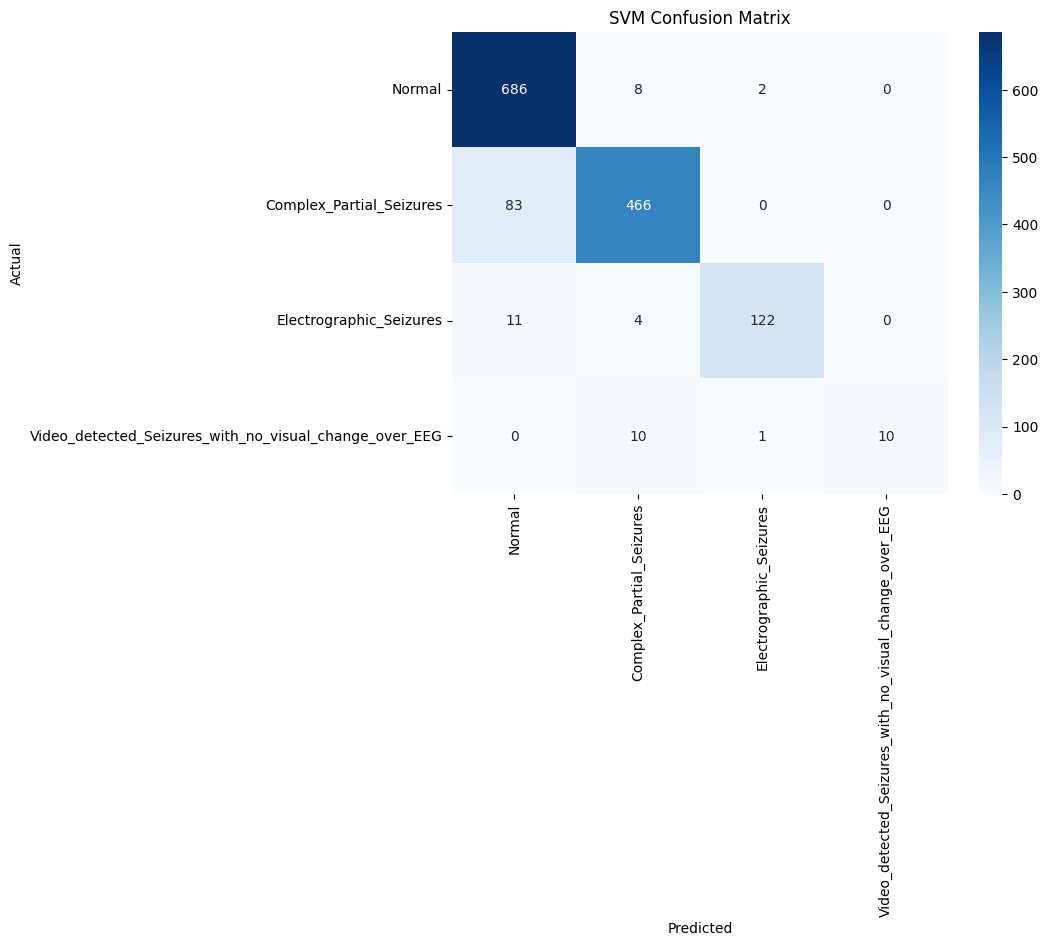

In [7]:
# Evaluate on validation set
val_predictions = svm_model.predict(val_features)
val_probabilities = svm_model.decision_function(val_features)  # Use decision_function for SVM probabilities

# Calculate metrics
val_accuracy = accuracy_score(val_labels, val_predictions)
val_balanced_accuracy = balanced_accuracy_score(val_labels, val_predictions)
val_f1_score = f1_score(val_labels, val_predictions, average='weighted')

# Calculate ROC AUC Score (multi-class One-vs-Rest approach)
val_roc_auc = roc_auc_score(
    pd.get_dummies(val_labels),  # Convert true labels to one-hot encoding
    val_probabilities,          # Decision function output
    multi_class='ovr',
    average='weighted'
)

# Confusion Matrix
conf_matrix = confusion_matrix(val_labels, val_predictions)

# Print Metrics
print(f"SVM Validation Accuracy: {val_accuracy:.4f}")
print(f"SVM Balanced Accuracy: {val_balanced_accuracy:.4f}")
print(f"SVM F1 Score: {val_f1_score:.4f}")
print(f"SVM ROC AUC Score: {val_roc_auc:.4f}")
print("SVM Classification Report:")
print(classification_report(val_labels, val_predictions))

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_mapping.keys(), yticklabels=class_mapping.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('SVM Confusion Matrix')
plt.show()

# 6. Running the model on the test data and saving it

In [8]:

test_predictions = svm_model.predict(test_features)

# Save predictions for unlabeled test data
results = pd.DataFrame({"Filename": test_filenames, "Prediction": test_predictions})
results.to_csv("test_predictions.csv", index=False)
print("Test predictions saved to test_predictions.csv.")

Test predictions saved to test_predictions.csv.


# 7. Experimenting with XGBoost 

In [9]:
from xgboost import XGBClassifier

In [10]:
# Initialize the XGBoost model
xgb_model = XGBClassifier(
    n_estimators=100,       # Number of trees
    max_depth=6,            # Maximum depth of trees
    learning_rate=0.1,      # Step size shrinkage
    subsample=0.8,          # Subsample ratio of the training set
    colsample_bytree=0.8,   # Subsample ratio of columns when constructing each tree
    random_state=42         # For reproducibility
)

# Train the XGBoost model
xgb_model.fit(train_features, train_labels)

# Predict on the validation set
xgb_val_predictions = xgb_model.predict(val_features)

XGBoost Validation Accuracy: 0.9601
XGBoost Validation F1 Score: 0.9601
XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       696
           1       0.97      0.96      0.96       549
           2       0.94      0.94      0.94       137
           3       1.00      0.90      0.95        21

    accuracy                           0.96      1403
   macro avg       0.97      0.94      0.95      1403
weighted avg       0.96      0.96      0.96      1403



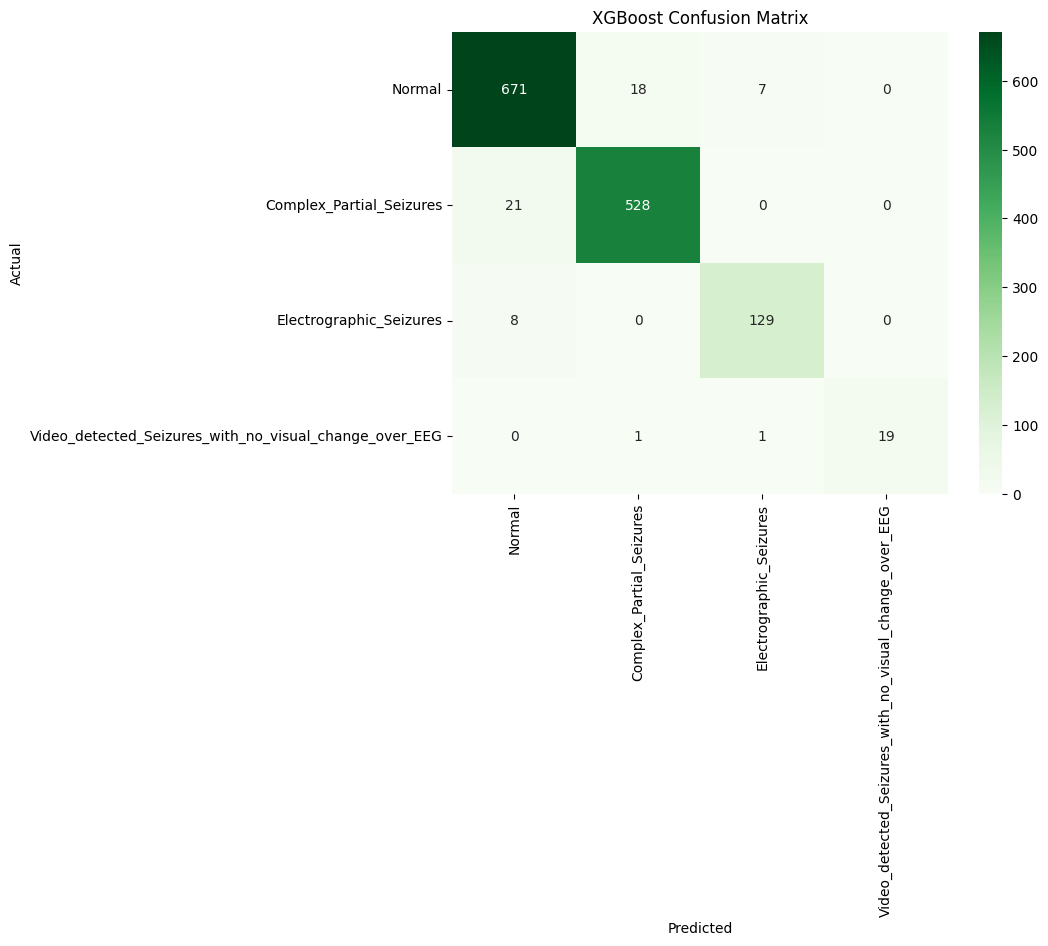

In [11]:
# Accuracy
xgb_val_accuracy = accuracy_score(val_labels, xgb_val_predictions)

# F1 Score
xgb_val_f1_score = f1_score(val_labels, xgb_val_predictions, average='weighted')

# Confusion Matrix
xgb_conf_matrix = confusion_matrix(val_labels, xgb_val_predictions)

# Print Results
print(f"XGBoost Validation Accuracy: {xgb_val_accuracy:.4f}")
print(f"XGBoost Validation F1 Score: {xgb_val_f1_score:.4f}")
print("XGBoost Classification Report:")
print(classification_report(val_labels, xgb_val_predictions))

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(xgb_conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=class_mapping.keys(), yticklabels=class_mapping.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('XGBoost Confusion Matrix')
plt.show()

In [12]:
xgb_test_predictions = xgb_model.predict(test_features)

# Save predictions for unlabeled test data
results = pd.DataFrame({"Filename": test_filenames, "Prediction": test_predictions})
results.to_csv("xgb_test_predictions.csv", index=False)
print("Test predictions saved to xgb_test_predictions.csv.")

Test predictions saved to xgb_test_predictions.csv.
